In [33]:

import sys
sys.path.append('/Users/bence/code/liouvillian_metro/')

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.linalg import expm
import pickle
from copy import deepcopy
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace, state_fidelity
import time

from oft_n_liouv_np import oft, liouvillian_evol, liouvillian_step
from tools.classical import find_ideal_heisenberg, trotter_step_heisenberg_qt, ham_evol_qt, \
    hamiltonian_matrix, HamHam

np.random.seed(667)

In [34]:
# coeffs = [1.1, 0.8, 0.2, 1]
# X = qt.sigmax()
# Y = qt.sigmay()
# Z = qt.sigmaz()

# constr_times = []
# diag_times = []
# for n in range(4, 13, 1):
#     print(f'Number of qubits: {n}')

#     t0 = time.time()
#     hamiltonian_qt = hamiltonian_matrix([X, X], [Y, Y], [Z, Z], coeffs=coeffs, num_qubits=n, symbreak_term=[Z])
#     t1 = time.time()
#     eigenenergies, eigenstates = np.linalg.eigh(hamiltonian_qt)
#     t2 = time.time()
#     diag_times.append(t2 - t1)
#     constr_times.append(t1 - t0)
#     print(f'Construction time: {t1 - t0}')
#     print(f'Diagonalization time: {t2 - t1}')


In [35]:
#plot the results
# plt.figure()
# plt.plot(range(4, 13, 1), constr_times, label='Construction time')
# plt.plot(range(4, 13, 1), diag_times, label='Diagonalization time')
# plt.xlabel('Number of qubits')
# plt.ylabel('Time (s)')


$n = 3, k = 6$

$n = 4, k = 8$

In [42]:
num_qubits = 10
num_energy_bits = 11
delta = 0.01
eps = 0.1
sigma = 5
bohr_bound = 0 # 2 ** (-num_energy_bits + 1)
beta = 1
eig_index = 2
mix_time = 4

hamiltonian = find_ideal_heisenberg(num_qubits, bohr_bound, eps, signed=False, for_oft=True)

initial_state = hamiltonian.eigvecs[:, eig_index]
initial_dm = initial_state @ initial_state.conj().T

Original spectrum:  [-11.5267 -11.4285  -9.987  ...  10.0914  11.2809  11.6738]
Ideal spectrum:  [0.     0.0019 0.0299 ... 0.4193 0.4424 0.45  ]
Nonrescaled coefficients:  [0.127 0.988 0.638 0.366]
Rescaled coefficients:  [0.00246332 0.01916343 0.01237477 0.007099  ]


In [37]:
# Get the diagonal elements of the Hermitian matrix (real part only)
diag_ham = np.diagflat(hamiltonian.spectrum)

In [38]:
# Create Gibbs state from eigenstates and eigenenergies
gibbs = expm(-beta * hamiltonian.qt.full()) / np.trace(expm(-beta * hamiltonian.qt.full()))
print(gibbs.shape)

(256, 256)


In [46]:
# Liouvillian, could be from (1.8), i.e. integral over the energies

N = 2**num_energy_bits
N_labels = np.arange(N / 2, dtype=int)
N_labels_neg = np.arange(- N / 2, 0, dtype=int)
N_labels = np.concatenate((N_labels, N_labels_neg))
energy_labels = 2 * np.pi * N_labels / N 
time_labels = N_labels

# rand_jump_index = np.random.randint(0, num_qubits)ú
site_list = [qt.qeye(2) for _ in range(num_qubits)]
x_jump_ops = []
for q in range(num_qubits):
    site_list[q] = qt.sigmax()
    x_jump_ops.append(qt.tensor(site_list).full())

### With Qutip MESOLVE

In [44]:
def trdist_to_gibbs(t, state):
    gibbs = qt.Qobj(expm(-beta * hamiltonian.qt.full()) / np.trace(expm(-beta * hamiltonian.qt.full())))
    trdist = qt.tracedist(state, gibbs)
    # print(f'Trace distance to Gibbs at time {t} is {trdist}')
    return trdist

def fid_with_gibbs(t, state):
    gibbs = qt.Qobj(expm(-beta * hamiltonian.qt.full()) / np.trace(expm(-beta * hamiltonian.qt.full())))
    fid = qt.fidelity(state, gibbs)
    # print(f'Fidelity with Gibbs at time {t} is {fid}')
    return fid

all_oft_jump_ops = []
for i in range(len(x_jump_ops)):
    jump_op = x_jump_ops[i]
    for phase in N_labels:
        energy = 2 * np.pi * phase / N
        oft_op = oft(jump_op, phase, N, sigma, hamiltonian)
        all_oft_jump_ops.append(qt.Qobj(oft_op))

no_H = qt.qeye(2**num_qubits)
times = np.linspace(0.0, mix_time, 10)
result_qt = qt.mesolve(no_H, qt.Qobj(initial_dm), times, all_oft_jump_ops, 
                       e_ops=[trdist_to_gibbs, fid_with_gibbs], options=qt.Options(store_states=True))


KeyboardInterrupt: 

In [ ]:
print(f'Last trace distance to Gibbs is {result_qt.expect[0][-1]}')
print(f'Last fid value is {result_qt.expect[1][-1]}')

Last trace distance to Gibbs is (0.06205031075214684+0j)
Last fid value is (0.9976526882717122+0j)


<string>:2: SyntaxWarning: invalid escape sequence '\{'
<string>:2: SyntaxWarning: invalid escape sequence '\}'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\}'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<string>:2: SyntaxWarning: invalid escape sequence '\}'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\}'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_47672/1639833590.py:2: SyntaxWarning: invalid escape sequence '\{'
  plt.title(f'$e^{{\mathcal{{L}}t}}$, with $A = \{

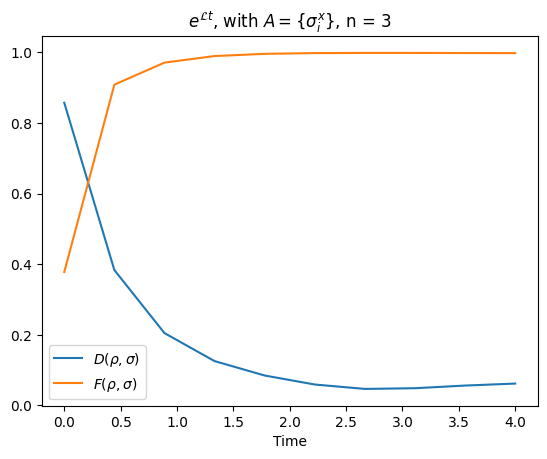

In [ ]:
plt.figure() 
plt.title(f'$e^{{\mathcal{{L}}t}}$, with $A = \{{\sigma_i^x\}}$, n = {num_qubits}')
plt.plot(times, result_qt.expect[0]) 
plt.plot(times, result_qt.expect[1]) 
plt.xlabel('Time') 
plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$")) 
plt.show() 

### $\left[ \mathbb{I} + \mathcal{L}\delta + \mathcal{O}(\delta^2) \right] \times \lceil t_{mix} / \delta \rceil$

In [ ]:
# def alg_liouv_evolve(initial_dm: np.ndarray, time: float, delta: float, jump_ops: list[np.ndarray]) -> np.ndarray:
#     """
#     time evolution is between [0, time]
#     `jump_ops`: non-OFT form
#     """
    
#     num_liouv_steps = int(np.ceil(time / delta))
    
#     N = 2**num_energy_bits
#     N_labels = np.arange(N / 2, dtype=int)
#     N_labels_neg = np.arange(- N / 2, 0, dtype=int)
#     N_labels = np.concatenate((N_labels, N_labels_neg))
    
#     boltzmann = lambda beta, energy: np.min([1, np.exp(-beta * energy)])
    
#     evolved_dms = []
#     evolved_dm = deepcopy(initial_dm)
#     #* Exact
#     for liouv_step in range(num_liouv_steps): #? Normalize?
#         print(f'Liouv step {liouv_step}')
        
#         rand_jump_index = np.random.randint(0, len(jump_ops))
#         jump_op = jump_ops[rand_jump_index]
#         print(f'Jump on site {rand_jump_index}')
        
#         previous_dm = deepcopy(evolved_dm) / np.trace(evolved_dm)
#         for phase in N_labels:
#             energy = 2 * np.pi * phase / N
#             oft_op = oft(jump_op, phase, N, sigma, hamiltonian=hamiltonian)
#             evolved_dm += delta * boltzmann(beta, energy)*(-0.5 * oft_op.conj().T @ oft_op @ previous_dm
#                                             -0.5 * previous_dm @ oft_op.conj().T @ oft_op
#                                             + oft_op @ previous_dm @ oft_op.conj().T)

#         evolved_dms.append(evolved_dm / np.trace(evolved_dm))
        
#     return evolved_dms

# alg_evolved_dms = alg_liouv_evolve(initial_dm, mix_time*3, delta, jump_ops=x_jump_ops)


In [ ]:
# exact_state_at_t = lambda t: result_qt.states[np.argmin(np.abs(times - t))]
#? Why can the fidelity be over 1 in larger delta cases? Is it because it somehow deviates after a while from a CPTP map
#? And for that Fidelity becomes inappropriate, even if we normalize the states?

exact_state = result_qt.states[-1] / np.trace(result_qt.states[-1])

trdist_alg_exact = qt.tracedist(qt.Qobj(alg_evolved_dms[-1]), exact_state)
fid_alg_exact = qt.fidelity(qt.Qobj(alg_evolved_dms[-1]), exact_state)
print(f'Trace distance between exact evol and alg is {trdist_alg_exact}')
print(f'Fidelity between exact evol and alg is {fid_alg_exact}')

trdist_alg_gibbs = qt.tracedist(qt.Qobj(alg_evolved_dms[-1]), qt.Qobj(gibbs))
fid_alg_gibbs = qt.fidelity(qt.Qobj(alg_evolved_dms[-1]), qt.Qobj(gibbs))
print(f'Trace distance between Gibbs and alg is {trdist_alg_gibbs}')
print(f'Fidelity between Gibbs and alg is {fid_alg_gibbs}')

NameError: name 'alg_evolved_dms' is not defined

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_70097/3881565001.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathbb{I} + \mathcal{L}\delta + \mathcal{O}(\delta^2)$ with $A\in\{\sigma_i^x\}$')
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_70097/3881565001.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$"))
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_70097/3881565001.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$")

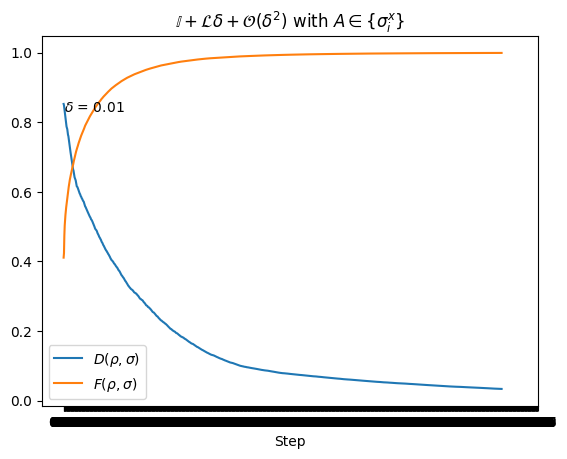

In [ ]:
liouv_times = np.linspace(0.0, mix_time*3, len(alg_evolved_dms))
fid_alg_with_gibbs = [qt.fidelity(qt.Qobj(dm), qt.Qobj(gibbs)) for dm in alg_evolved_dms]
trdist_alg_with_gibbs = [qt.tracedist(qt.Qobj(dm), qt.Qobj(gibbs)) for dm in alg_evolved_dms]
plt.figure() 
plt.title('$\mathbb{I} + \mathcal{L}\delta + \mathcal{O}(\delta^2)$ with $A\in\{\sigma_i^x\}$')
plt.plot(liouv_times, trdist_alg_with_gibbs) 
plt.plot(liouv_times, fid_alg_with_gibbs) 
plt.xlabel('Step')
plt.xticks(np.arange(0, mix_time*3 + 1, delta))
plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$"))
plt.annotate(f'$\delta$ = {delta}', xy=(0, 0.83))
plt.show() 

### Spectral gap / mixing time

In [45]:
all_oft_jump_ops = []
for i in range(len(x_jump_ops)):
    jump_op = x_jump_ops[i]
    for phase in N_labels:
        energy = 2 * np.pi * phase / 2**num_energy_bits
        oft_op = oft(jump_op, phase, 2**num_energy_bits, sigma, hamiltonian)
        all_oft_jump_ops.append(qt.Qobj(oft_op))

no_H = qt.qeye(2**num_qubits)
liouvillian = qt.liouvillian(no_H, c_ops=all_oft_jump_ops)

KeyboardInterrupt: 

In [ ]:
spectrum = liouvillian.eigenenergies()
spectral_gap = spectrum[-1] - spectrum[-2]
print(f'Spectral gap {spectral_gap}')
smallest_gibbs_ev = qt.Qobj(gibbs).eigenenergies()[0]
print(f'Smallest eigenvalue of Gibbs state {smallest_gibbs_ev}')

desired_trdist = 0.3
mixing_time_bound = (np.log(np.sqrt(1 / smallest_gibbs_ev)) -np.log(desired_trdist)) / spectral_gap
print(f'Mixing time bound {mixing_time_bound}')

Spectral gap 0.3255278319257359
Smallest eigenvalue of Gibbs state 0.09497093525296871
Mixing time bound 7.314474402047588


In [41]:
# 8 -10: 7.4s;  
jump_op = x_jump_ops[0]
t0 = time.time()
liouv_step_evolved_dm = liouvillian_step(initial_dm, beta, delta, jump_op, N, sigma, hamiltonian)
print(f'Liouvillian step time {time.time() - t0}')

(256, 256)
Liouvillian step time 7.434053182601929
